# Attempt to extract refractive index from time domain

In [1]:
import torch
import numpy as np
from Matrix_methods.Simulate import simulate_reference, simulate_parallel, c 
import matplotlib.pyplot as plt

from TimeDomain_extractor import TimeDomainExtractor

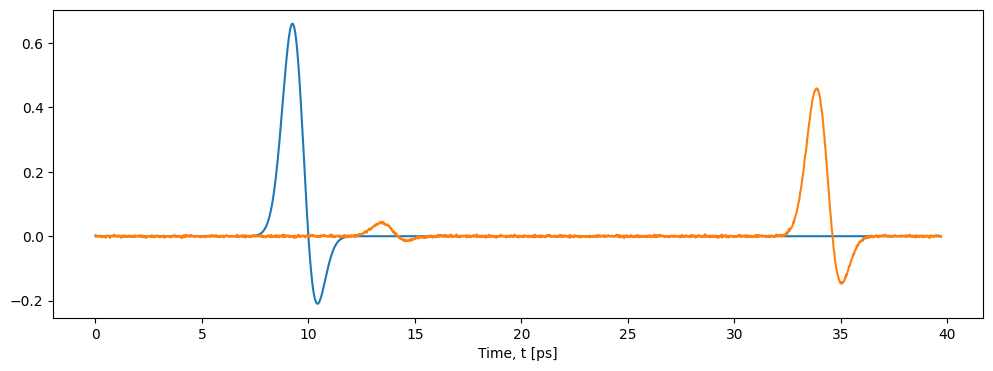

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**11  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

# Experimental material parameters (ground truth)
material_params_exp = [(3.46, 3 * 1e-3)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0.002)
experimental_pulse = experimental_pulse[:L]


plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

In [3]:
# Initial guesses
n_init, k_init, D_init = 3.45, 0, 3e-3

# Create and run the optimizer
extractor = TimeDomainExtractor(reference_pulse, experimental_pulse, deltat, n_init, k_init, D_init, lr=0.01)
optimized_n, optimized_k, optimized_D = extractor.optimize(num_iterations=100, updates=10)

initial_params = [(n_init + 1j*k_init, D_init)]
initial_pulse = simulate_parallel(reference_pulse, initial_params, deltat)[1][:L]

Iteration 0, Loss: 0.001872876426205039, n: 3.4600000381469727, k: 0.0, D: 0.0030301508959382772
Iteration 10, Loss: 0.0007941904477775097, n: 3.4519267082214355, k: 0.0, D: 0.003007427556440234
Iteration 20, Loss: 0.00011394769535399973, n: 3.451263904571533, k: 0.0, D: 0.0030043129809200764
Iteration 30, Loss: 0.00033595223794691265, n: 3.452178716659546, k: 0.0, D: 0.003004661062732339
Iteration 40, Loss: 0.00012589387188199908, n: 3.4540910720825195, k: 0.0, D: 0.0030072382651269436
Iteration 50, Loss: 0.00011673138214973733, n: 3.4552576541900635, k: 0.0, D: 0.0030070862267166376
Iteration 60, Loss: 8.040500688366592e-05, n: 3.455538034439087, k: 0.0, D: 0.0030042026191949844
Iteration 70, Loss: 8.023504778975621e-05, n: 3.456650495529175, k: 0.0, D: 0.0030041567515581846
Iteration 80, Loss: 8.17337422631681e-05, n: 3.457308292388916, k: 0.0, D: 0.0030030827037990093
Iteration 90, Loss: 7.37920418032445e-05, n: 3.4579362869262695, k: 0.0, D: 0.0030023609288036823


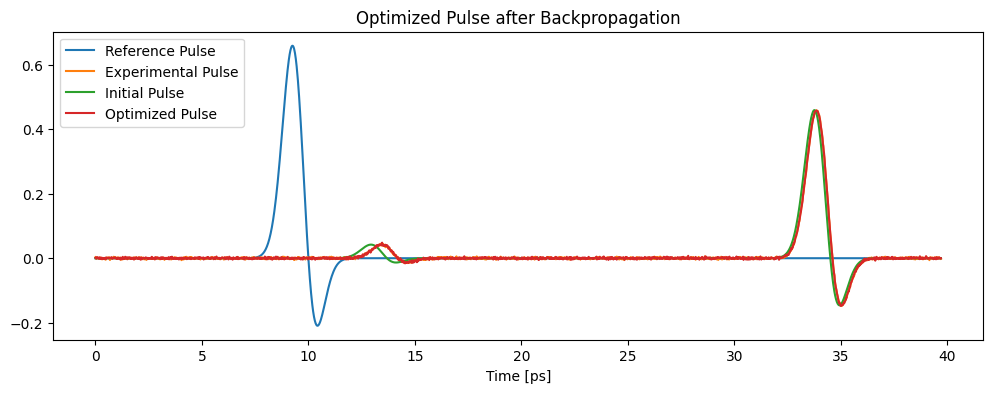

In [4]:
# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, extractor.forward().detach().numpy(), label='Optimized Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()

In [5]:
print(f'forward pass single run time: {extractor.forward_time}s')
print(f'backwards pass single run time: {extractor.backwards_time}s')
print(f'optimizer single run time: {extractor.optimizer_time}s')

forward pass single run time: 0.3292028330033645s
backwards pass single run time: 0.5979642500169575s
optimizer single run time: 0.00016545801190659404s


In [6]:
print(f'forward pass 100 iter run time: {extractor.forward_time * 100} s')
print(f'backwards pass 100 iter run time: {extractor.backwards_time * 100} s')
print(f'optimizer 100 iter run time: {extractor.optimizer_time * 100} s')

forward pass 100 iter run time: 32.92028330033645 s
backwards pass 100 iter run time: 59.79642500169575 s
optimizer 100 iter run time: 0.016545801190659404 s
